In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from PIL import ImageOps, Image
import numpy as np


import pandas as pd
import json 
import tensorflow as tf
from keras import utils
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold


In [2]:
# my specific error/bug on gpu, dont run 
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_virtual_device_configuration(device, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

    

In [3]:
df = pd.read_csv("awe-translation.csv")
df['AWE image path'] = df['AWE image path'].apply(lambda x: "awe/"+x )

subjects = df["Subject ID"].unique()
subjects, df.columns


(array([ 11,   1,  12,   2,  13,  14,  15,  16,  17,  18,  19,  20,  21,
         22,  23,   3,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
         34,  35,   4,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
         46,  47,   5,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,   6,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,
         71,   7,  72,   8,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,   9,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  10,  96,  97,  98,  99, 100,  67]),
 Index(['AWE-Full image path', 'AWE image path', 'Subject ID'], dtype='object'))

In [4]:
# add gender and ethnicity to dataframe
def gender(image_path):
    file = annotation_file(image_path)
    
    with open(file) as json_file: 
        data = json.load(json_file)
        
        if data["gender"] == "m":
            return 0
        elif data["gender"] == "f":
            return 1
        else:
            raise Exception()
            
def ethnicity(image_path):
    file = annotation_file(image_path)
    
    with open(file) as json_file: 
        data = json.load(json_file)
        
        return data["ethnicity"]
    
def annotation_file(image_path):
    image_path_split = image_path.split('/')
    json_file = "/".join(image_path_split[:-1])
    json_file += "/annotations.json"
    return json_file

df["gender"] = df['AWE image path'].apply(lambda x: gender(x) )
df["ethnicity"] = df['AWE image path'].apply(lambda x: ethnicity(x) )

# convert 99 -> 7
df["ethnicity"] = df["ethnicity"].apply(lambda x: 7 if x == 99 else x)
df["ids"] = df["Subject ID"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AWE-Full image path  1000 non-null   object
 1   AWE image path       1000 non-null   object
 2   Subject ID           1000 non-null   int64 
 3   gender               1000 non-null   int64 
 4   ethnicity            1000 non-null   int64 
 5   ids                  1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [5]:
def from_hotbit(array):
    
    return np.argmax(array, axis=-1)

def to_hotbit(array):
    return utils.to_categorical(array)

# dataf- dataframe, analyse_column - which column will be analised, is_train for training data
def build_X_y(dataf, analyse_column , is_train=False):
    images = []
    images_mirror = []
    for path in dataf["AWE image path"]:
        img_original = image.load_img(path, target_size=(224, 224))
        # convert the image pixels to a numpy array
        img = image.img_to_array(img_original)
        # reshape data for the model
        # prepare the image for the
        img = preprocess_input(img)
        images.append(img)

        img_mirror = ImageOps.mirror(img_original)

        img = image.img_to_array(img_original)
        # reshape data for the model
        # prepare the image for the
        img = preprocess_input(img)
        images_mirror.append(img)
    
    X = np.array(images)
    X_mirror = np.array(images_mirror)
    y = np.array(to_hotbit(dataf[analyse_column]))

    if is_train:
        X = np.concatenate((X, X_mirror))
        y = np.concatenate((y, y))

    return X, y

def calculate_cmc(y_pred, y_test, num_ranks=10):

    ranks = num_ranks
    rank_scores = np.zeros(ranks)

    for el_pred, el_true in zip(y_pred, y_test):   
        for r in range(ranks):
            r_max_val_ind = np.argsort(el_pred)[-(r+1):][0]
            r_max_val = el_pred[r_max_val_ind]
            correct_ranks = ((el_pred >= r_max_val) * 1)

            yind = np.argmax(el_true, axis=-1)
            if correct_ranks[yind] == 1:
                rank_scores[r] += 1


    rank_scores = rank_scores / y_pred.shape[0]
    return rank_scores

,AWE-Full image path,AWE image path,Subject ID,gender,ethnicity,ids
0,test/0001.png,awe/011/07.png,11,0,2,11
641,train/0392.png,awe/006/04.png,6,0,5,6


Epoch 1/100
43/43 [==============================] - 8s 195ms/step - loss: 5.1284 - val_loss: 6.1119
Epoch 2/100
43/43 [==============================] - 6s 138ms/step - loss: 2.9811 - val_loss: 6.0068
Epoch 3/100
43/43 [==============================] - 6s 139ms/step - loss: 1.7451 - val_loss: 4.3934
Epoch 4/100
43/43 [==============================] - 6s 139ms/step - loss: 0.9769 - val_loss: 3.4008
Epoch 5/100
43/43 [==============================] - 6s 138ms/step - loss: 0.5983 - val_loss: 1.6494
Epoch 6/100
43/43 [==============================] - 6s 139ms/step - loss: 0.3268 - val_loss: 2.4578
Epoch 7/100
43/43 [==============================] - 6s 138ms/step - loss: 0.2060 - val_loss: 2.8696
Epoch 1/100
43/43 [==============================] - 8s 196ms/step - loss: 2.3642 - val_loss: 0.7203
Epoch 2/100
43/43 [==============================] - 7s 170ms/step - loss: 1.6214 - val_loss: 0.7854
Epoch 3/100
43/43 [==============================] - 7s 172ms/step - loss: 1.2852 - val_los

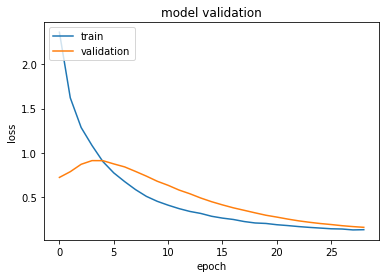

/home/aljaz/miniconda3/envs/sb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
43/43 [==============================] - 7s 159ms/step - loss: 5.0772 - val_loss: 5.0609
Epoch 2/100
43/43 [==============================] - 6s 140ms/step - loss: 2.9965 - val_loss: 4.2585
Epoch 3/100
43/43 [==============================] - 6s 140ms/step - loss: 1.7408 - val_loss: 3.8968
Epoch 4/100
43/43 [==============================] - 6s 140ms/step - loss: 0.9720 - val_loss: 3.7127
Epoch 5/100
43/43 [==============================] - 6s 141ms/step - loss: 0.5434 - val_loss: 1.9618
Epoch 6/100
43/43 [==============================] - 6s 141ms/step - loss: 0.3006 - val_loss: 5.1975
Epoch 7/100
43/43 [==============================] - 6s 140ms/step - loss: 0.2455 - val_loss: 1.7583
Epoch 8/100
43/43 [==============================] - 6s 140ms/step - loss: 0.2171 - val_loss: 0.1021
Epoch 9/100
43/43 [==============================] - 6s 140ms/step - loss: 0.1578 - val_loss: 0.0517
Epoch 10/100
43/43 [==============================] - 6s 139ms/step - loss: 0.1015 - val_lo

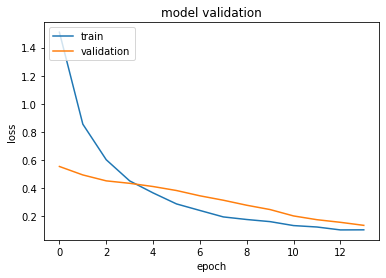

Epoch 1/100
43/43 [==============================] - 7s 158ms/step - loss: 5.2507 - val_loss: 5.1000
Epoch 2/100
43/43 [==============================] - 6s 140ms/step - loss: 2.9864 - val_loss: 5.9033
Epoch 3/100
43/43 [==============================] - 6s 141ms/step - loss: 1.7851 - val_loss: 4.3245
Epoch 4/100
43/43 [==============================] - 6s 140ms/step - loss: 0.9633 - val_loss: 2.0603
Epoch 5/100
43/43 [==============================] - 6s 140ms/step - loss: 0.5653 - val_loss: 0.9287
Epoch 6/100
43/43 [==============================] - 6s 140ms/step - loss: 0.2921 - val_loss: 1.5749
Epoch 7/100
43/43 [==============================] - 6s 141ms/step - loss: 0.2127 - val_loss: 0.8563
Epoch 8/100
43/43 [==============================] - 6s 140ms/step - loss: 0.1734 - val_loss: 0.0404
Epoch 9/100
43/43 [==============================] - 6s 140ms/step - loss: 0.1119 - val_loss: 0.0237
Epoch 10/100
43/43 [==============================] - 6s 140ms/step - loss: 0.1286 - val_lo

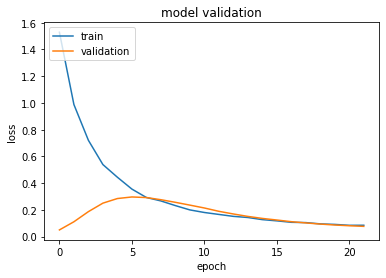

Epoch 1/100
43/43 [==============================] - 7s 158ms/step - loss: 5.4576 - val_loss: 5.5740
Epoch 2/100
43/43 [==============================] - 6s 140ms/step - loss: 3.1511 - val_loss: 5.5792
Epoch 3/100
43/43 [==============================] - 6s 140ms/step - loss: 1.9118 - val_loss: 4.7235
Epoch 4/100
43/43 [==============================] - 6s 140ms/step - loss: 1.1425 - val_loss: 2.8099
Epoch 5/100
43/43 [==============================] - 6s 140ms/step - loss: 0.6088 - val_loss: 2.0548
Epoch 6/100
43/43 [==============================] - 6s 141ms/step - loss: 0.3526 - val_loss: 2.8134
Epoch 7/100
43/43 [==============================] - 6s 140ms/step - loss: 0.2818 - val_loss: 4.1166
Epoch 1/100
43/43 [==============================] - 9s 201ms/step - loss: 2.5764 - val_loss: 0.7021
Epoch 2/100
43/43 [==============================] - 7s 174ms/step - loss: 1.7327 - val_loss: 0.6831
Epoch 3/100
43/43 [==============================] - 7s 174ms/step - loss: 1.3548 - val_los

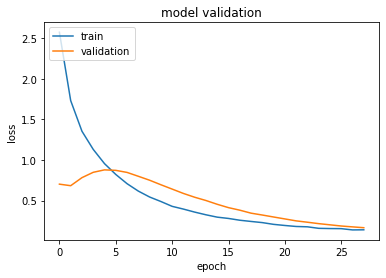

Epoch 1/100
43/43 [==============================] - 7s 159ms/step - loss: 3.2477 - val_loss: 1.6592
Epoch 2/100
43/43 [==============================] - 6s 140ms/step - loss: 1.2384 - val_loss: 2.9958
Epoch 3/100
43/43 [==============================] - 6s 140ms/step - loss: 1.0872 - val_loss: 0.8631
Epoch 4/100
43/43 [==============================] - 6s 140ms/step - loss: 0.7745 - val_loss: 0.8555
Epoch 5/100
43/43 [==============================] - 6s 140ms/step - loss: 0.7085 - val_loss: 0.8335
Epoch 6/100
43/43 [==============================] - 6s 140ms/step - loss: 0.5126 - val_loss: 0.7473
Epoch 7/100
43/43 [==============================] - 6s 140ms/step - loss: 0.4477 - val_loss: 0.4737
Epoch 8/100
43/43 [==============================] - 6s 140ms/step - loss: 0.3353 - val_loss: 0.8102
Epoch 9/100
43/43 [==============================] - 6s 141ms/step - loss: 0.2971 - val_loss: 0.5140
Epoch 1/100
43/43 [==============================] - 8s 193ms/step - loss: 0.6550 - val_los

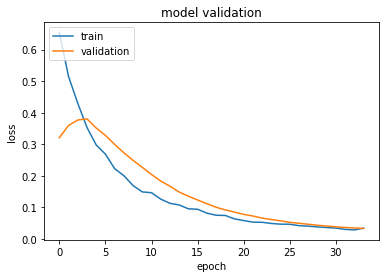

/home/aljaz/miniconda3/envs/sb/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100
43/43 [==============================] - 7s 153ms/step - loss: 3.1648 - val_loss: 1.8258
Epoch 2/100
43/43 [==============================] - 6s 136ms/step - loss: 1.2091 - val_loss: 1.2132
Epoch 3/100
43/43 [==============================] - 6s 138ms/step - loss: 1.0164 - val_loss: 2.4620
Epoch 4/100
43/43 [==============================] - 6s 138ms/step - loss: 0.7944 - val_loss: 0.9612
Epoch 5/100
43/43 [==============================] - 6s 135ms/step - loss: 0.6599 - val_loss: 0.6483
Epoch 6/100
43/43 [==============================] - 6s 143ms/step - loss: 0.5004 - val_loss: 0.6527
Epoch 7/100
43/43 [==============================] - 6s 138ms/step - loss: 0.4287 - val_loss: 0.8027
Epoch 1/100
43/43 [==============================] - 8s 186ms/step - loss: 0.8418 - val_loss: 0.4388
Epoch 2/100
43/43 [==============================] - 7s 170ms/step - loss: 0.6196 - val_loss: 0.4677
Epoch 3/100
43/43 [==============================] - 7s 174ms/step - loss: 0.5436 - val_los

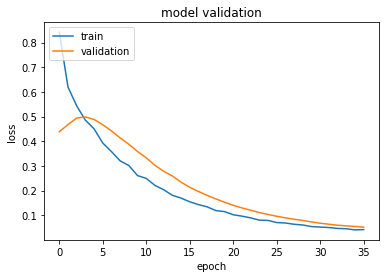

Epoch 1/100
43/43 [==============================] - 7s 160ms/step - loss: 3.1124 - val_loss: 1.6349
Epoch 2/100
43/43 [==============================] - 6s 136ms/step - loss: 1.2983 - val_loss: 0.9381
Epoch 3/100
43/43 [==============================] - 6s 136ms/step - loss: 0.9688 - val_loss: 0.7681
Epoch 4/100
43/43 [==============================] - 6s 136ms/step - loss: 0.8566 - val_loss: 1.9766
Epoch 5/100
43/43 [==============================] - 6s 137ms/step - loss: 0.6610 - val_loss: 1.1561
Epoch 1/100
43/43 [==============================] - 8s 192ms/step - loss: 1.1204 - val_loss: 0.7944
Epoch 2/100
43/43 [==============================] - 8s 181ms/step - loss: 0.9145 - val_loss: 0.6727
Epoch 3/100
43/43 [==============================] - 8s 182ms/step - loss: 0.7932 - val_loss: 0.6439
Epoch 4/100
43/43 [==============================] - 8s 189ms/step - loss: 0.7345 - val_loss: 0.6416
Epoch 5/100
43/43 [==============================] - 8s 179ms/step - loss: 0.6714 - val_los

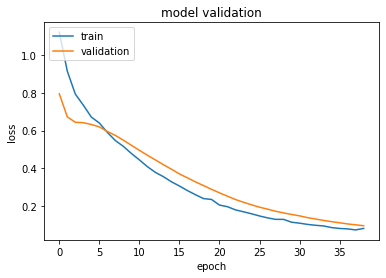

Epoch 1/100
43/43 [==============================] - 7s 157ms/step - loss: 2.8701 - val_loss: 4.1887
Epoch 2/100
43/43 [==============================] - 6s 139ms/step - loss: 1.2551 - val_loss: 1.3874
Epoch 3/100
43/43 [==============================] - 6s 140ms/step - loss: 1.0337 - val_loss: 1.3439
Epoch 4/100
43/43 [==============================] - 6s 137ms/step - loss: 0.7980 - val_loss: 1.0786
Epoch 5/100
43/43 [==============================] - 6s 137ms/step - loss: 0.6557 - val_loss: 1.2529
Epoch 6/100
43/43 [==============================] - 6s 137ms/step - loss: 0.5474 - val_loss: 1.5975
Epoch 1/100
43/43 [==============================] - 8s 195ms/step - loss: 1.0458 - val_loss: 0.8521
Epoch 2/100
43/43 [==============================] - 7s 174ms/step - loss: 0.7832 - val_loss: 0.6938
Epoch 3/100
43/43 [==============================] - 7s 172ms/step - loss: 0.6703 - val_loss: 0.6815
Epoch 4/100
43/43 [==============================] - 8s 175ms/step - loss: 0.5927 - val_los

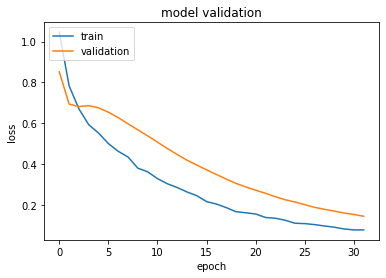

Epoch 1/100
43/43 [==============================] - 7s 160ms/step - loss: 0.7787 - val_loss: 0.1613
Epoch 2/100
43/43 [==============================] - 6s 138ms/step - loss: 0.1972 - val_loss: 0.1368
Epoch 3/100
43/43 [==============================] - 6s 135ms/step - loss: 0.1456 - val_loss: 0.4004
Epoch 4/100
43/43 [==============================] - 6s 140ms/step - loss: 0.1268 - val_loss: 0.0879
Epoch 5/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0754 - val_loss: 0.0586
Epoch 6/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0660 - val_loss: 0.0456
Epoch 7/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0638 - val_loss: 0.0210
Epoch 8/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0589 - val_loss: 0.0141
Epoch 9/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0041 - val_loss: 0.0655
Epoch 10/100
43/43 [==============================] - 6s 138ms/step - loss: 0.0857 - val_lo

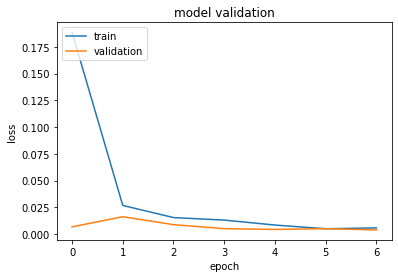

Epoch 1/100
43/43 [==============================] - 7s 153ms/step - loss: 1.0715 - val_loss: 0.7872
Epoch 2/100
43/43 [==============================] - 6s 138ms/step - loss: 0.4370 - val_loss: 1.1823
Epoch 3/100
43/43 [==============================] - 6s 137ms/step - loss: 0.2925 - val_loss: 0.1640
Epoch 4/100
43/43 [==============================] - 6s 134ms/step - loss: 0.1903 - val_loss: 0.5525
Epoch 5/100
43/43 [==============================] - 6s 136ms/step - loss: 0.1891 - val_loss: 1.4145
Epoch 1/100
43/43 [==============================] - 8s 189ms/step - loss: 0.9096 - val_loss: 0.7273
Epoch 2/100
43/43 [==============================] - 7s 173ms/step - loss: 0.3415 - val_loss: 0.3581
Epoch 3/100
43/43 [==============================] - 8s 177ms/step - loss: 0.1407 - val_loss: 0.2014
Epoch 4/100
43/43 [==============================] - 8s 177ms/step - loss: 0.0705 - val_loss: 0.1350
Epoch 5/100
43/43 [==============================] - 8s 177ms/step - loss: 0.0487 - val_los

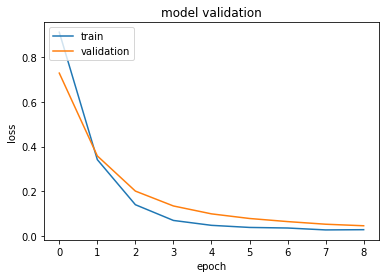

Epoch 1/100
43/43 [==============================] - 7s 159ms/step - loss: 0.7108 - val_loss: 0.3441
Epoch 2/100
43/43 [==============================] - 6s 136ms/step - loss: 0.2727 - val_loss: 0.1345
Epoch 3/100
43/43 [==============================] - 6s 136ms/step - loss: 0.2305 - val_loss: 0.1128
Epoch 4/100
43/43 [==============================] - 6s 139ms/step - loss: 0.1736 - val_loss: 0.0824
Epoch 5/100
43/43 [==============================] - 6s 148ms/step - loss: 0.1184 - val_loss: 0.0540
Epoch 6/100
43/43 [==============================] - 6s 147ms/step - loss: 0.0969 - val_loss: 0.3419
Epoch 7/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0858 - val_loss: 0.0483
Epoch 8/100
43/43 [==============================] - 6s 137ms/step - loss: 0.0615 - val_loss: 0.0307
Epoch 9/100
43/43 [==============================] - 6s 138ms/step - loss: 0.0240 - val_loss: 0.0428
Epoch 10/100
43/43 [==============================] - 7s 155ms/step - loss: 0.0828 - val_lo

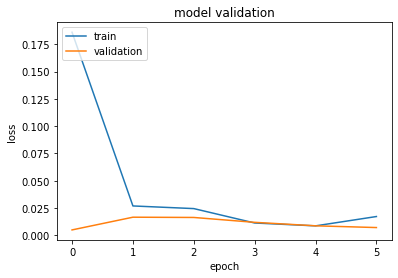

Epoch 1/100
43/43 [==============================] - 7s 156ms/step - loss: 0.6827 - val_loss: 0.3033
Epoch 2/100
43/43 [==============================] - 6s 135ms/step - loss: 0.2487 - val_loss: 0.2107
Epoch 3/100
43/43 [==============================] - 6s 136ms/step - loss: 0.1851 - val_loss: 0.0960
Epoch 4/100
43/43 [==============================] - 6s 138ms/step - loss: 0.1139 - val_loss: 0.1326
Epoch 5/100
43/43 [==============================] - 6s 138ms/step - loss: 0.1223 - val_loss: 0.0368
Epoch 6/100
43/43 [==============================] - 6s 140ms/step - loss: 0.0888 - val_loss: 0.0144
Epoch 7/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0617 - val_loss: 1.2736
Epoch 8/100
43/43 [==============================] - 6s 137ms/step - loss: 0.1567 - val_loss: 0.0093
Epoch 9/100
43/43 [==============================] - 6s 136ms/step - loss: 0.0195 - val_loss: 0.0136
Epoch 10/100
43/43 [==============================] - 6s 137ms/step - loss: 0.0241 - val_lo

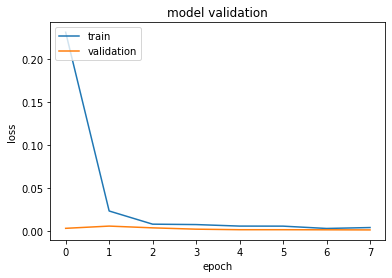

In [6]:

final_scores = {}

for use_on_column in ["ids","ethnicity", "gender"]:
    
    # use stratified - important for IDs
    kf = StratifiedKFold(n_splits=4)
    
    scores = {
        "f1": [],
        "precision": [],
        "recall": [],
        "rank1": [], #aka accuracy
        "rank5": [],
        "cmc": [],
    }
    for train_index, test_index in kf.split(df, df[use_on_column]):

        df_train = df.iloc[train_index,]
        df_test = df.iloc[test_index,]
        
        X_train, y_train = build_X_y(df_train, use_on_column, is_train=True)
        X_test, y_test = build_X_y(df_test, use_on_column, is_train=False)
        
        #tf.keras.backend.clear_session()

        # create the base pre-trained model
        base_model = InceptionV3(weights='imagenet', include_top=False)

        # add a global spatial average pooling layer
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        # let's add a fully-connected layer
        x = Dense(1024, activation='relu')(x)

        # and a logistic layer -- 
        predictions = Dense(y_train.shape[1], activation='softmax')(x)

        # this is the model we will train
        model = Model(inputs=base_model.input, outputs=predictions)

        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all convolutional InceptionV3 layers
        for layer in base_model.layers:
            layer.trainable = False

        # compile the model (should be done *after* setting layers to non-trainable)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
        
        es = EarlyStopping(monitor='val_loss', mode='min', patience=2)

        history = model.fit(X_train,y_train, validation_split=0.1, shuffle= True, epochs=100, callbacks=[es], batch_size=32)

        
        # at this point, the top layers are well trained and we can start fine-tuning
        # convolutional layers from inception V3. We will freeze the bottom N layers
        # and train the remaining top layers.


        # we chose to train the top 2 inception blocks, i.e. we will freeze
        # the first 249 layers and unfreeze the rest:
        for layer in model.layers[:249]:
            layer.trainable = False
        for layer in model.layers[249:]:
            layer.trainable = True

        # we need to recompile the model for these modifications to take effect
        # we use SGD with a low learning rate
        from tensorflow.keras.optimizers import SGD
        model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

        # we train our model again (this time fine-tuning the top 2 inception blocks
        # alongside the top Dense layers
        es = EarlyStopping(monitor='loss', mode='min', patience=1)

        history = model.fit(X_train,y_train, validation_split=0.1, shuffle= True, epochs=100, callbacks=[es], batch_size=32)
        
        # summarize history for accuracy
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model validation')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','validation'], loc='upper left')
        plt.show()      
        
        y_pred = model.predict(X_test)

        ranks = 15
        cmc = calculate_cmc(y_pred, y_test, num_ranks=ranks)
        
        max_values = np.amax(y_pred, axis=1)
        # get hotbit value
        res = []
        for i in range(y_pred.shape[0]):
            each_image_hotbit_pred = (max_values[i] == y_pred[i]) *1
            res.append(each_image_hotbit_pred)

        y_pred_bi = np.array(res)

        y_pred_hot = from_hotbit(y_pred_bi)
        y_test_hot = from_hotbit(y_test)


        prec, rec, f1, _ = metrics.precision_recall_fscore_support(y_test_hot, y_pred_hot, average='weighted')
        
        scores["f1"].append(f1)
        scores["precision"].append(prec)
        scores["recall"].append(rec)
        scores["rank1"].append(cmc[0])
        scores["rank5"].append(cmc[4])
        scores["cmc"].append(cmc)
    
    final_scores[use_on_column] = scores

{'f1': [0.9297344173441736,
  0.8938266796494644,
  0.9535567245868538,
  0.9210444292549557],
 'precision': [0.9280984278879016,
  0.907560975609756,
  0.9533563218390805,
  0.9191035460992908],
 'recall': [0.932, 0.92, 0.956, 0.928],
 'rank1': [0.932, 0.92, 0.956, 0.928],
 'rank5': [1.0, 1.0, 1.0, 1.0],
 'cmc': [array([0.932, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   , 1.   ]),
  array([0.92, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
         1.  , 1.  , 1.  , 1.  ]),
  array([0.956, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   , 1.   ]),
  array([0.928, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
         1.   , 1.   , 1.   , 1.   , 1.   , 1.   ])]}

array([0.01341641, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

for column ids
Average F1 0.18024603174603177 0.01893194512545681
Average Precision 0.20559761904761906 0.01659295587914511
Average Recall 0.19 0.021633307652783935
Average Rank 1 0.19 0.021633307652783935
Average Rank 5 0.448 0.040693979898751606
---------------
for column ethnicity
Average F1 0.589622183630385 0.009119901234193494
Average Precision 0.5784122957889921 0.023345946514871867
Average Recall 0.638 0.01754992877478426
Average Rank 1 0.638 0.01754992877478426
Average Rank 5 0.978 0.004472135954999583
---------------
for column gender
Average F1 0.9245405627088619 0.021356962200980552
Average Precision 0.9270298178590073 0.01685295479835638
Average Recall 0.9339999999999999 0.013416407864998705
Average Rank 1 0.9339999999999999 0.013416407864998705
Average Rank 5 1.0 0.0
---------------


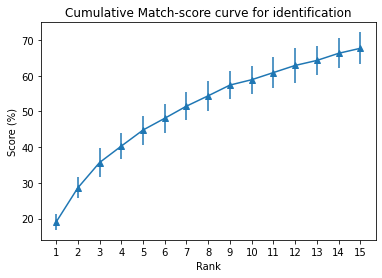

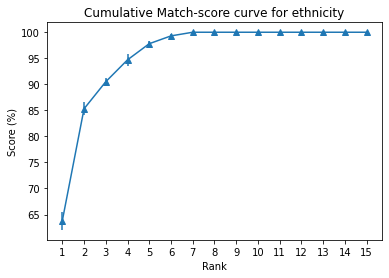

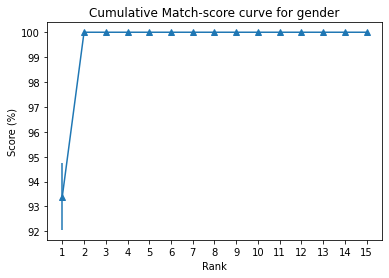

In [21]:
for column in final_scores:
    print("for column", column)
    scores = final_scores[column]
    
    print("Average F1", np.mean(scores["f1"]), np.std(scores["f1"]))
    print("Average Precision", np.mean(scores["precision"]), np.std(scores["precision"]))
    print("Average Recall", np.mean(scores["recall"]), np.std(scores["recall"]))
    print("Average Rank 1", np.mean(scores["rank1"]), np.std(scores["rank1"]))
    print("Average Rank 5", np.mean(scores["rank5"]), np.std(scores["rank5"]))

    mapper = {
        "gender": "gender",
        "ethnicity" : "ethnicity",
        "ids": "identification"
    }
    
    
    
    
    plt.figure(figsize=(6,4))

    cmc = np.mean(np.array(scores["cmc"]).T*100, axis=1)
    cmce = np.std(np.array(scores["cmc"]).T*100, axis=1)
    
    #for cmc in scores["cmc"]:

     #   plt.plot(np.arange(1,ranks+1), cmc*100)
        
    plt.errorbar(np.arange(1,ranks+1), cmc, cmce, marker='^')

    plt.title(f"Cumulative Match-score curve for {mapper[column]}")
    plt.xlabel("Rank")
    plt.xticks(np.arange(1,ranks+1))
    plt.ylabel("Score (%)")

    print("---------------")
    

In [192]:
"""
for column ids
Average F1 0.18024603174603177 0.01893194512545681
Average Precision 0.20559761904761906 0.01659295587914511
Average Recall 0.19 0.021633307652783935
Average Rank 1 0.19 0.021633307652783935
Average Rank 5 0.448 0.040693979898751606
rank1 score: 0.22
rank5 score: 0.504
---------------
for column ethnicity
Average F1 0.589622183630385 0.009119901234193494
Average Precision 0.5784122957889921 0.023345946514871867
Average Recall 0.638 0.01754992877478426
Average Rank 1 0.638 0.01754992877478426
Average Rank 5 0.978 0.004472135954999583
rank1 score: 0.664
rank5 score: 0.984
---------------
for column gender
Average F1 0.9245405627088619 0.021356962200980552
Average Precision 0.9270298178590073 0.01685295479835638
Average Recall 0.9339999999999999 0.013416407864998705
Average Rank 1 0.9339999999999999 0.013416407864998705
Average Rank 5 1.0 0.0
rank1 score: 0.928
rank5 score: 1.0
---------------

"""

